# Feature Engineering for Activity Recognition

This notebook demonstrates feature extraction techniques for time-series sensor data:
- Time-domain features (statistical measures)
- Frequency-domain features (FFT-based)
- Windowing strategies for raw time-series

The UCI HAR dataset provides pre-computed features, but we also demonstrate how to extract features from raw sensor data.

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Add src to path
sys.path.insert(0, str(Path("../src").resolve()))

from fittrack.data.ingestion import HARDataLoader, ACTIVITY_LABELS
from fittrack.features.engineering import (
    FeatureConfig,
    FeatureExtractor,
    extract_time_domain_features,
    extract_frequency_domain_features,
    extract_har_features,
    create_windows,
    compute_sma,
    compute_zero_crossing_rate,
)

plt.style.use("seaborn-v0_8-whitegrid")
%matplotlib inline

FIGURES_DIR = Path("../docs/figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

/sessions/zen-jolly-cori/.local/lib/python3.10/site-packages/pandera/_pandas_deprecated.py:157: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


## 1. Load UCI HAR Dataset

In [2]:
loader = HARDataLoader()
train_data, test_data = loader.load_all()

print(f"Training samples: {train_data.n_samples:,}")
print(f"Features per sample: {train_data.n_features}")

Training samples: 7,352
Features per sample: 561


## 2. Feature Subset Extraction

The UCI HAR dataset has 561 pre-computed features. Let's explore different subsets.

In [3]:
# Extract feature subsets
time_features = extract_har_features(train_data.X, feature_subset="time")
body_acc_features = extract_har_features(train_data.X, feature_subset="body_acc")
gyro_features = extract_har_features(train_data.X, feature_subset="gyro")

print(f"Time-domain features: {time_features.shape[1]}")
print(f"Body acceleration features: {body_acc_features.shape[1]}")
print(f"Gyroscope features: {gyro_features.shape[1]}")

Time-domain features: 265
Body acceleration features: 292
Gyroscope features: 213


In [4]:
# Feature naming breakdown
all_features = train_data.X.columns.tolist()

# Count by type
feature_types = {
    "mean()": len([f for f in all_features if "mean()" in f]),
    "std()": len([f for f in all_features if "std()" in f]),
    "mad()": len([f for f in all_features if "mad()" in f]),
    "max()": len([f for f in all_features if "max()" in f]),
    "min()": len([f for f in all_features if "min()" in f]),
    "energy()": len([f for f in all_features if "energy()" in f]),
    "entropy()": len([f for f in all_features if "entropy()" in f]),
}

print("Feature type counts:")
for ftype, count in sorted(feature_types.items(), key=lambda x: -x[1]):
    print(f"  {ftype}: {count}")

Feature type counts:
  mean(): 33
  std(): 33
  mad(): 33
  max(): 33
  min(): 33
  energy(): 33
  entropy(): 33


## 3. Time-Domain Feature Extraction Demo

Demonstrate extracting time-domain features from a synthetic signal.

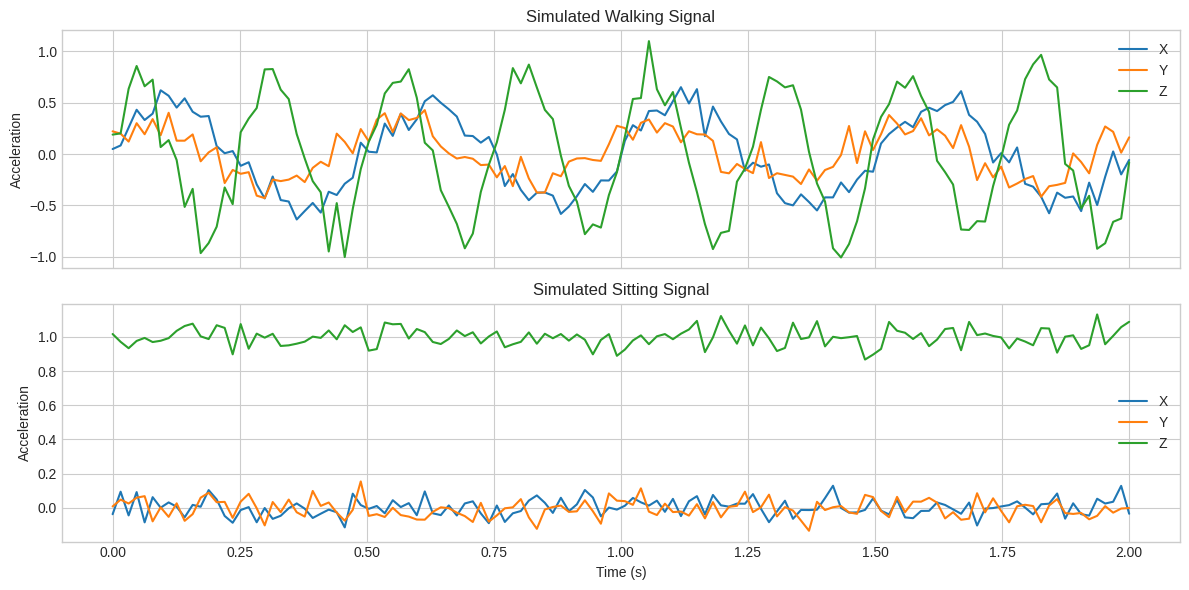

In [5]:
# Create synthetic accelerometer data (3-axis)
np.random.seed(42)
t = np.linspace(0, 2, 128)  # 2 seconds at 64Hz

# Simulate walking: periodic signal with noise
walking_x = 0.5 * np.sin(2 * np.pi * 2 * t) + 0.1 * np.random.randn(128)  # 2Hz stride
walking_y = 0.3 * np.sin(2 * np.pi * 2 * t + np.pi/4) + 0.1 * np.random.randn(128)
walking_z = 0.8 * np.sin(2 * np.pi * 4 * t) + 0.15 * np.random.randn(128)  # 4Hz vertical
walking_signal = np.column_stack([walking_x, walking_y, walking_z])

# Simulate sitting: mostly static with small noise
sitting_signal = 0.05 * np.random.randn(128, 3)
sitting_signal[:, 2] += 1.0  # Gravity component

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(t, walking_signal)
axes[0].set_ylabel("Acceleration")
axes[0].set_title("Simulated Walking Signal")
axes[0].legend(["X", "Y", "Z"])

axes[1].plot(t, sitting_signal)
axes[1].set_ylabel("Acceleration")
axes[1].set_xlabel("Time (s)")
axes[1].set_title("Simulated Sitting Signal")
axes[1].legend(["X", "Y", "Z"])

plt.tight_layout()
plt.show()

In [6]:
# Extract time-domain features
walking_features = extract_time_domain_features(walking_signal, ["X", "Y", "Z"])
sitting_features = extract_time_domain_features(sitting_signal, ["X", "Y", "Z"])

# Compare key features
comparison_df = pd.DataFrame({
    "Feature": list(walking_features.keys()),
    "Walking": list(walking_features.values()),
    "Sitting": list(sitting_features.values()),
})
comparison_df["Difference"] = abs(comparison_df["Walking"] - comparison_df["Sitting"])

# Show features with largest differences
print("Features with largest activity differences:")
print(comparison_df.nlargest(10, "Difference").to_string(index=False))

Features with largest activity differences:
 Feature   Walking  Sitting  Difference
   min_Z -1.006168 0.867452    1.873620
 range_Z  2.106298 0.264168    1.842130
 range_X  1.287956 0.243764    1.044192
median_Z  0.004315 0.997253    0.992938
  mean_Z  0.006159 0.998706    0.992547
   iqr_Z  1.026168 0.072396    0.953772
energy_Z  0.330038 1.000143    0.670105
   iqr_X  0.688317 0.064862    0.623456
 range_Y  0.856497 0.288788    0.567708
   max_X  0.651931 0.128668    0.523263


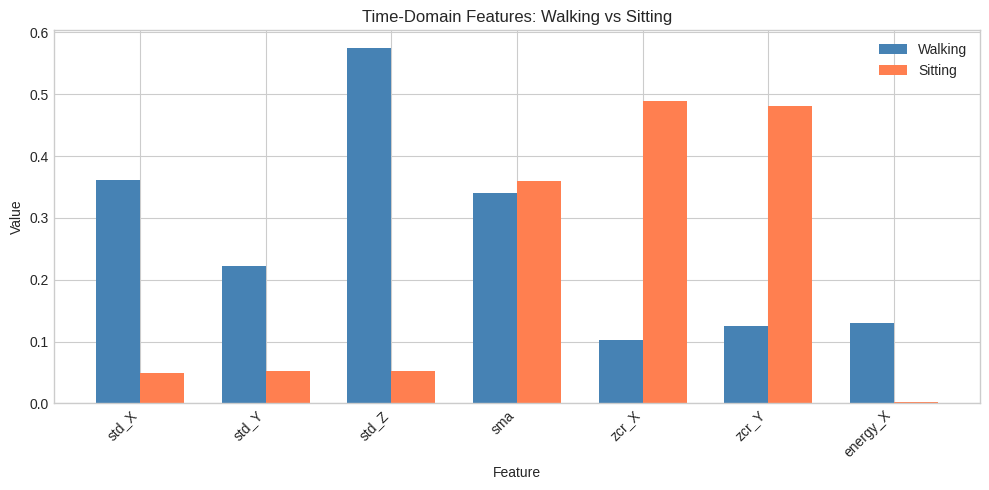

In [7]:
# Visualize feature differences
key_features = ["std_X", "std_Y", "std_Z", "sma", "zcr_X", "zcr_Y", "energy_X"]

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(key_features))
width = 0.35

walking_vals = [walking_features[f] for f in key_features]
sitting_vals = [sitting_features[f] for f in key_features]

ax.bar(x - width/2, walking_vals, width, label="Walking", color="steelblue")
ax.bar(x + width/2, sitting_vals, width, label="Sitting", color="coral")
ax.set_xlabel("Feature")
ax.set_ylabel("Value")
ax.set_title("Time-Domain Features: Walking vs Sitting")
ax.set_xticks(x)
ax.set_xticklabels(key_features, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / "time_domain_features.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Frequency-Domain Feature Extraction

In [8]:
# Extract frequency features
walking_freq_features = extract_frequency_domain_features(
    walking_signal, sampling_rate=64.0, n_coeffs=5, axis_names=["X", "Y", "Z"]
)
sitting_freq_features = extract_frequency_domain_features(
    sitting_signal, sampling_rate=64.0, n_coeffs=5, axis_names=["X", "Y", "Z"]
)

print("Walking - Dominant frequencies:")
print(f"  X: {walking_freq_features['dominant_freq_X']:.2f} Hz")
print(f"  Y: {walking_freq_features['dominant_freq_Y']:.2f} Hz")
print(f"  Z: {walking_freq_features['dominant_freq_Z']:.2f} Hz")

print("\nSitting - Dominant frequencies:")
print(f"  X: {sitting_freq_features['dominant_freq_X']:.2f} Hz")
print(f"  Y: {sitting_freq_features['dominant_freq_Y']:.2f} Hz")
print(f"  Z: {sitting_freq_features['dominant_freq_Z']:.2f} Hz")

Walking - Dominant frequencies:
  X: 2.00 Hz
  Y: 2.00 Hz
  Z: 4.00 Hz

Sitting - Dominant frequencies:
  X: 28.50 Hz
  Y: 13.00 Hz
  Z: 20.50 Hz


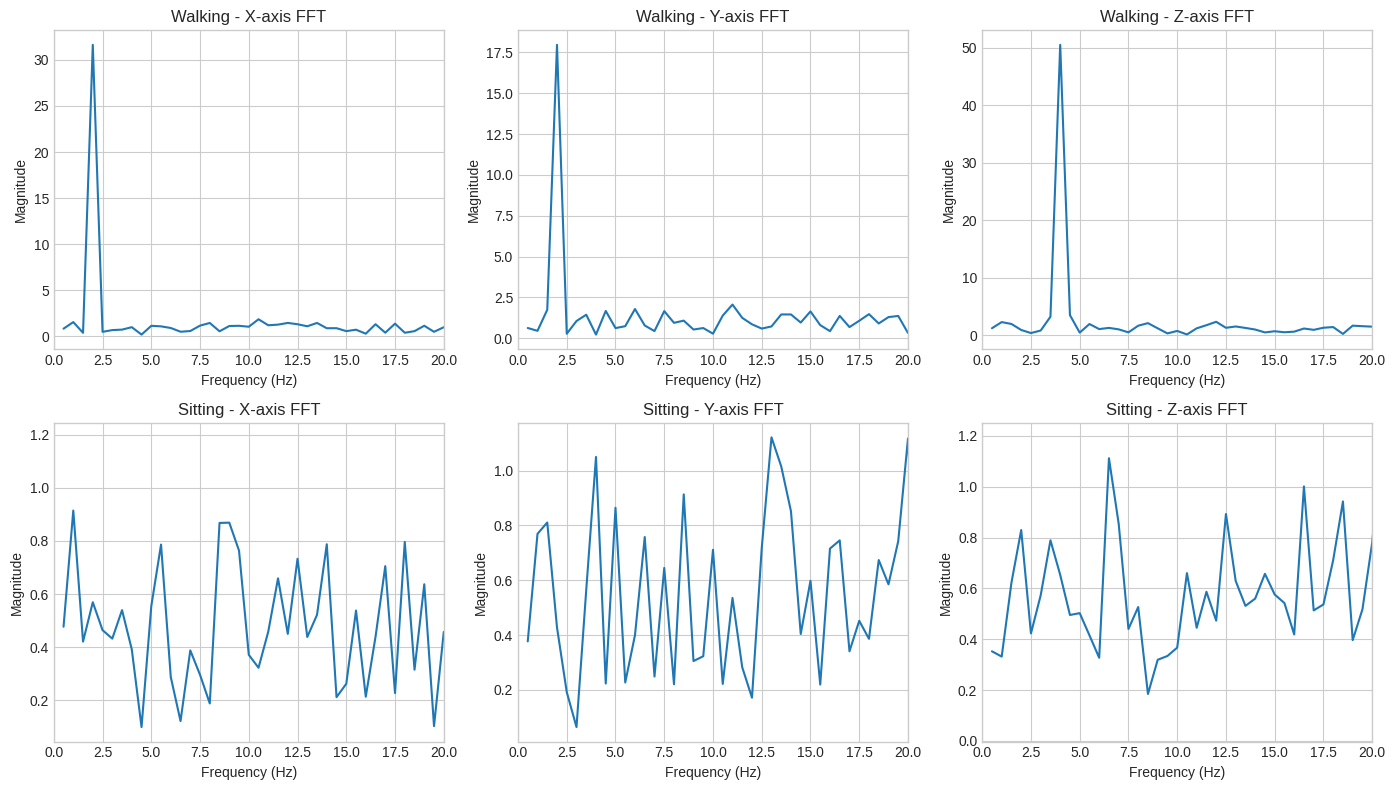

In [9]:
# Visualize FFT
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for i, (signal, name) in enumerate([(walking_signal, "Walking"), (sitting_signal, "Sitting")]):
    for j, axis in enumerate(["X", "Y", "Z"]):
        ax = axes[i, j]
        fft_vals = np.fft.rfft(signal[:, j])
        freqs = np.fft.rfftfreq(len(signal), d=1/64.0)
        
        ax.plot(freqs[1:], np.abs(fft_vals[1:]), linewidth=1.5)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Magnitude")
        ax.set_title(f"{name} - {axis}-axis FFT")
        ax.set_xlim(0, 20)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "fft_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## 5. Windowing for Raw Time-Series

In [10]:
# Demonstrate windowing
raw_signal = np.random.randn(500, 3)  # 500 samples, 3 axes

# Different overlap strategies
windows_50 = create_windows(raw_signal, window_size=64, overlap=0.5)
windows_75 = create_windows(raw_signal, window_size=64, overlap=0.75)
windows_0 = create_windows(raw_signal, window_size=64, overlap=0.0)

print(f"500 samples with window_size=64:")
print(f"  50% overlap: {windows_50.shape[0]} windows")
print(f"  75% overlap: {windows_75.shape[0]} windows")
print(f"   0% overlap: {windows_0.shape[0]} windows")

500 samples with window_size=64:
  50% overlap: 14 windows
  75% overlap: 28 windows
   0% overlap: 7 windows


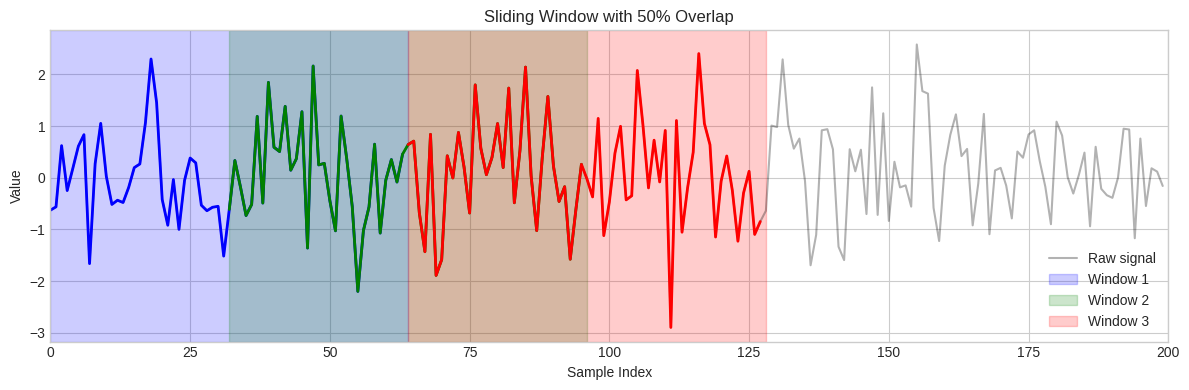

In [11]:
# Visualize windowing
fig, ax = plt.subplots(figsize=(12, 4))

signal_1d = raw_signal[:200, 0]  # First 200 samples, first axis
ax.plot(signal_1d, 'k-', alpha=0.3, label="Raw signal")

# Show first 3 windows
colors = ['blue', 'green', 'red']
for i in range(3):
    start = i * 32  # 50% overlap with window_size=64
    end = start + 64
    ax.axvspan(start, end, alpha=0.2, color=colors[i], label=f"Window {i+1}")
    ax.plot(range(start, end), signal_1d[start:end], color=colors[i], linewidth=2)

ax.set_xlabel("Sample Index")
ax.set_ylabel("Value")
ax.set_title("Sliding Window with 50% Overlap")
ax.legend()
ax.set_xlim(0, 200)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "windowing_demo.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Full Feature Extraction Pipeline

In [12]:
# Configure feature extractor
config = FeatureConfig(
    include_time_domain=True,
    include_frequency_domain=True,
    window_size=128,
    window_overlap=0.5,
    n_fft_coeffs=10,
)

extractor = FeatureExtractor(config)

# Generate longer synthetic data
np.random.seed(42)
t_long = np.linspace(0, 10, 640)  # 10 seconds

# Walking signal
walking_long = np.column_stack([
    0.5 * np.sin(2 * np.pi * 2 * t_long) + 0.1 * np.random.randn(640),
    0.3 * np.sin(2 * np.pi * 2 * t_long + np.pi/4) + 0.1 * np.random.randn(640),
    0.8 * np.sin(2 * np.pi * 4 * t_long) + 0.15 * np.random.randn(640),
])

# Extract features
features_df = extractor.extract_features(
    walking_long,
    axis_names=["X", "Y", "Z"],
    sampling_rate=64.0,
)

print(f"Extracted {len(features_df)} windows")
print(f"Features per window: {len(features_df.columns)}")
print(f"\nFeature columns:")
print(features_df.columns.tolist()[:20], "...")

Extracted 9 windows
Features per window: 75

Feature columns:
['mean_X', 'std_X', 'min_X', 'max_X', 'range_X', 'median_X', 'zcr_X', 'energy_X', 'iqr_X', 'entropy_X', 'mean_Y', 'std_Y', 'min_Y', 'max_Y', 'range_Y', 'median_Y', 'zcr_Y', 'energy_Y', 'iqr_Y', 'entropy_Y'] ...


In [13]:
# Show feature statistics across windows
print("\nFeature statistics across windows:")
features_df.describe().T.head(15)


Feature statistics across windows:


,count,mean,std,min,25%,50%,75%,max
mean_X,9.0,-0.000117,0.007330,-0.014390,-0.004263,0.003384,0.004939,0.007570
std_X,9.0,0.366950,0.010446,0.351827,0.361187,0.362661,0.376958,0.381436
min_X,9.0,-0.639587,0.064828,-0.729526,-0.691894,-0.633545,-0.579002,-0.576182
max_X,9.0,0.669438,0.029626,0.629854,0.658216,0.663103,0.684430,0.734204
range_X,9.0,1.309025,0.076569,1.213690,1.263432,1.279752,1.392629,1.426098
median_X,9.0,0.003104,0.021928,-0.031852,-0.003282,0.007067,0.013644,0.037466
zcr_X,9.0,0.083115,0.020874,0.055118,0.070866,0.070866,0.102362,0.110236
energy_X,9.0,0.134797,0.007675,0.123840,0.130501,0.131567,0.142116,0.145505
iqr_X,9.0,0.661470,0.035139,0.599951,0.636917,0.679604,0.681357,0.713883
entropy_X,9.0,2.235766,0.029206,2.185331,2.210508,2.239459,2.256674,2.273789


## 7. Feature Importance Analysis (UCI HAR)

Analyze which pre-computed features in UCI HAR are most discriminative.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(train_data.y["activity"])

# Quick RF for feature importance (subset for speed)
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(train_data.X, y_encoded)

# Get feature importances
importance_df = pd.DataFrame({
    "feature": train_data.X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print("Top 20 most important features:")
print(importance_df.head(20).to_string(index=False))

Top 20 most important features:
                          feature  importance
             tGravityAcc-mean()-X    0.048437
             angle(X,gravityMean)    0.037043
             tGravityAcc-mean()-Y    0.033576
              tGravityAcc-min()-X    0.028067
             angle(Y,gravityMean)    0.022918
              tGravityAcc-max()-X    0.021887
              tGravityAcc-min()-Y    0.020134
              tGravityAcc-max()-Y    0.019433
           tGravityAcc-energy()-X    0.017203
             angle(Z,gravityMean)    0.016353
           tGravityAcc-energy()-Y    0.014838
            fBodyAccJerk-mean()-X    0.013315
             tBodyAccJerk-std()-X    0.012848
  fBodyAccJerk-bandsEnergy()-1,24    0.012427
               tBodyAccJerk-sma()    0.012395
            tBodyGyroJerk-iqr()-Z    0.012279
             tGravityAccMag-std()    0.012196
fBodyAccJerk-bandsEnergy()-1,16_1    0.012118
             fBodyAcc-entropy()-X    0.012079
        tGravityAcc-arCoeff()-Z,2    0.012016


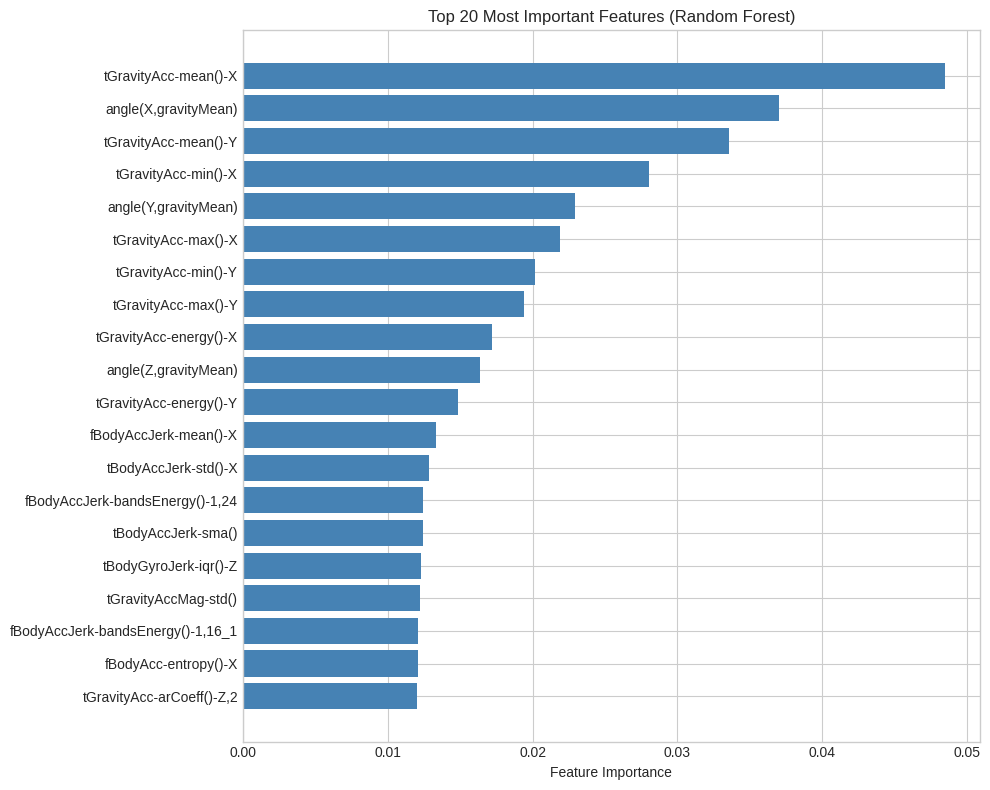

In [15]:
# Plot top features
fig, ax = plt.subplots(figsize=(10, 8))

top_20 = importance_df.head(20)
ax.barh(range(len(top_20)), top_20["importance"].values, color="steelblue")
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20["feature"].values)
ax.invert_yaxis()
ax.set_xlabel("Feature Importance")
ax.set_title("Top 20 Most Important Features (Random Forest)")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()

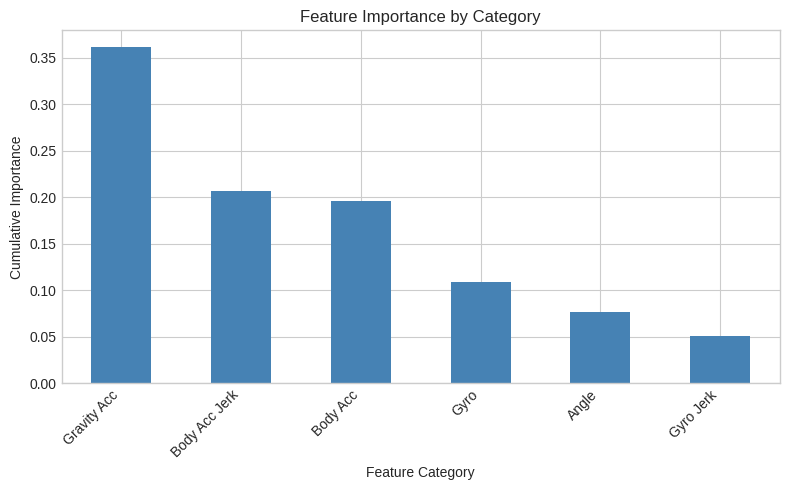

In [16]:
# Group importance by feature type
def categorize_feature(name):
    if "Acc" in name:
        if "Gravity" in name:
            return "Gravity Acc"
        elif "Jerk" in name:
            return "Body Acc Jerk"
        else:
            return "Body Acc"
    elif "Gyro" in name:
        if "Jerk" in name:
            return "Gyro Jerk"
        else:
            return "Gyro"
    elif "angle" in name:
        return "Angle"
    else:
        return "Other"

importance_df["category"] = importance_df["feature"].apply(categorize_feature)
category_importance = importance_df.groupby("category")["importance"].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 5))
category_importance.plot(kind="bar", ax=ax, color="steelblue")
ax.set_xlabel("Feature Category")
ax.set_ylabel("Cumulative Importance")
ax.set_title("Feature Importance by Category")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "feature_importance_by_category.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Summary

Key insights from feature engineering:

1. **Time-domain features** (mean, std, SMA, ZCR) effectively distinguish static vs dynamic activities
2. **Frequency-domain features** capture periodic patterns like walking stride frequency
3. **Gravity acceleration features** are most important for distinguishing activity types
4. **Body acceleration magnitude** and **angle features** are highly discriminative
5. **50% window overlap** is a good balance between data augmentation and computational cost

In [17]:
# List saved figures
print("Saved figures:")
for fig_path in sorted(FIGURES_DIR.glob("*.png")):
    print(f"  - {fig_path.name}")

Saved figures:
  - activity_feature_means.png
  - activity_profiles.png
  - activity_radar.png
  - class_distribution.png
  - correlation_heatmap.png
  - dimensionality_reduction.png
  - feature_boxplots.png
  - feature_distributions.png
  - feature_importance.png
  - feature_importance_by_category.png
  - fft_comparison.png
  - time_domain_features.png
  - train_test_distribution.png
  - windowing_demo.png
